# Library

In [1]:
%matplotlib inline
import datetime
timeformat = "%Y-%m-%d %H:%M:%S"

from sklearn import neural_network
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import plotly.plotly as py
from sklearn.metrics import mean_squared_error
from math import sqrt

plt.rcParams['figure.figsize'] = [16.0, 8.0]
colors = {'MLP':'C3', 'RT':'C2', 'LR':'C1', 'Real':'C0'}

# Global

In [2]:
predict = dict()
predict['datetime'], predict['RT'], predict['LR'], predict['MLP'] = [], [], [], []
rmse = dict()
rmse['datetime'], rmse['RT'], rmse['LR'], rmse['MLP'] = [], [], [], []
importances = pd.DataFrame()
coefficients = pd.DataFrame()

# Function

# Data preprocess

In [3]:
date_feature = pd.read_csv("../data/date_feature.csv", parse_dates=True)
time_series = pd.read_csv("../data/pm2.5_timeseries.csv", parse_dates=True)
meteorology = pd.read_csv("../data/Erlin.csv", parse_dates=True)

time_series = time_series[[column for column in time_series.columns if column not in ['datetime']]]
time_series = time_series[['t-6', 't-5', 't-4', 't-3', 't-2', 't-1']]
meteorology = meteorology[['AMB_TEMP', 'RAINFALL', 'RH', 'WIND_SPEED', 'PM2.5']]

## to forecast PM2.5(t), we use RAINFALL(t-1) instead of RAINFALL(t)
## cause we could not know RAINFALL(t) from weather forecast
meteorology.RAINFALL = meteorology.RAINFALL.shift()

data = pd.concat([meteorology, time_series, date_feature], axis=1)

target = "PM2.5"
exclude = ['datetime', target]
features = [f for f in data.columns if f not in exclude]

# Training

In [4]:
DateStart = '2016-12-01 00:00:00'
DateEnd = '2016-12-31 00:00:00'
TrainStart = data[data.datetime.values == '2016-01-01 00:00:00'].index[0]
regs = ['RT', 'LR', 'MLP']
now = datetime.datetime.strptime(DateStart, timeformat)
lastday =datetime.datetime.strptime(DateEnd, timeformat)

delta = datetime.timedelta(days=1)

while now < lastday:
    start_time = time.time()
    ## new iteration, train new model.
    y_start = now.strftime("%Y-%m-%d %H:%M:%S")
    now += delta
    y_end = now.strftime("%Y-%m-%d %H:%M:%S")
    print 'Time Period: ', y_start, '~', y_end
    
    start = data[data.datetime.values == y_start].index[0]
    end = data[data.datetime.values == y_end].index[0]
    
    train = data[TrainStart:start].dropna()
    test = data[start:end]
    
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    y_predict = dict()
    ## Regression Tree
    RT = AdaBoostRegressor(DecisionTreeRegressor())
    RT.fit(X_train, y_train)
    '''
    zipped = sorted(zip(features, RT.feature_importances_), key = lambda imp: imp[1])
    print 'Feature : Importances'
    for f, imp in zipped:
        print f, ':', imp
    '''
    imps = pd.DataFrame(dict(list(zip(features, RT.feature_importances_))), index=[0])
    importances = pd.concat([importances, imps], axis=0, ignore_index=True)

    y_predict['RT'] = RT.predict(X_test)

    ## Linear Regression
    LR = linear_model.LinearRegression()
    LR.fit(X_train, y_train)
    '''
    zipped = sorted(zip(features, LR.coef_), key = lambda coef: coef[1])
    print 'Feature : Coefficients'
    for f, coef in zipped:
        print f, ':', coef
    '''
    coefs = pd.DataFrame(dict(list(zip(features, LR.coef_))), index=[0])
    coefficients = pd.concat([coefficients, coefs], axis=0, ignore_index=True)
    
    y_predict['LR'] = LR.predict(X_test)

    ## MLP Regression
    MLP = neural_network.MLPRegressor(activation='relu')
    MLP.fit(X_train, y_train)
    '''print 'Model: \n', MLP'''

    y_predict['MLP'] = MLP.predict(X_test) 
    
    ## Measure
    predict['datetime'].extend(test.datetime.tolist())
    rmse['datetime'].append(y_start)
    
    
    for method in regs:
        predict[method].extend(y_predict[method].tolist())
        rmse[method].append(sqrt(mean_squared_error(y_predict[method], y_test)))
    
    ## end
    end_time = time.time()
    print "Time consume: ", end_time - start_time, ' s.'

Time Period:  2016-12-01 00:00:00 ~ 2016-12-02 00:00:00


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



Time consume:  5.21090197563  s.
Time Period:  2016-12-02 00:00:00 ~ 2016-12-03 00:00:00
Time consume:  4.64732289314  s.
Time Period:  2016-12-03 00:00:00 ~ 2016-12-04 00:00:00
Time consume:  5.46595096588  s.
Time Period:  2016-12-04 00:00:00 ~ 2016-12-05 00:00:00
Time consume:  5.431194067  s.
Time Period:  2016-12-05 00:00:00 ~ 2016-12-06 00:00:00
Time consume:  6.57971405983  s.
Time Period:  2016-12-06 00:00:00 ~ 2016-12-07 00:00:00
Time consume:  4.76889109612  s.
Time Period:  2016-12-07 00:00:00 ~ 2016-12-08 00:00:00
Time consume:  5.88733720779  s.
Time Period:  2016-12-08 00:00:00 ~ 2016-12-09 00:00:00
Time consume:  5.4227848053  s.
Time Period:  2016-12-09 00:00:00 ~ 2016-12-10 00:00:00
Time consume:  5.40867495537  s.
Time Period:  2016-12-10 00:00:00 ~ 2016-12-11 00:00:00
Time consume:  5.30923891068  s.
Time Period:  2016-12-11 00:00:00 ~ 2016-12-12 00:00:00
Time consume:  5.31471300125  s.
Time Period:  2016-12-12 00:00:00 ~ 2016-12-13 00:00:00
Time consume:  5.0748481

In [5]:
df_prdict = pd.DataFrame(predict)
df_rmse = pd.DataFrame(rmse)

real = data[data[data.datetime.values == DateStart].index[0] 
     : data[data.datetime.values == DateEnd].index[0]]['PM2.5'].tolist()

# Measure

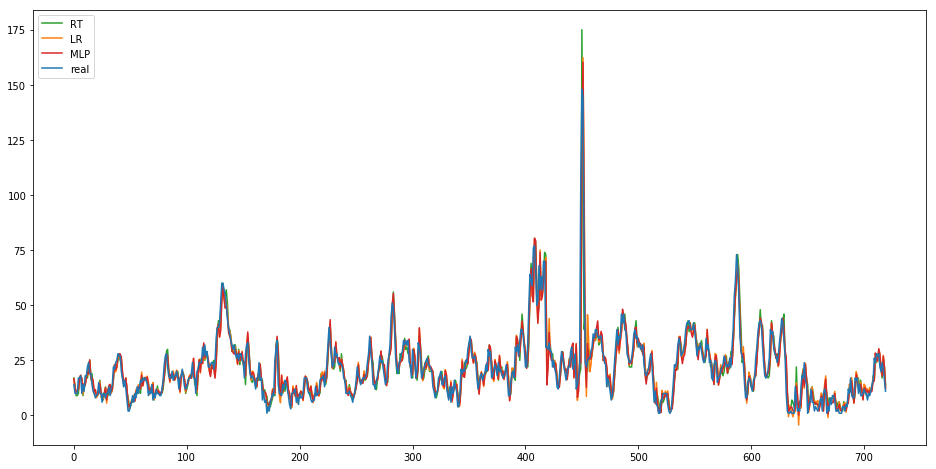

In [6]:
for reg in regs:
    plt.plot(df_prdict[reg], colors[reg], label = reg)

plt.plot(real, colors['Real'], label = 'real')
plt.legend(loc='upper left')
plt.show()

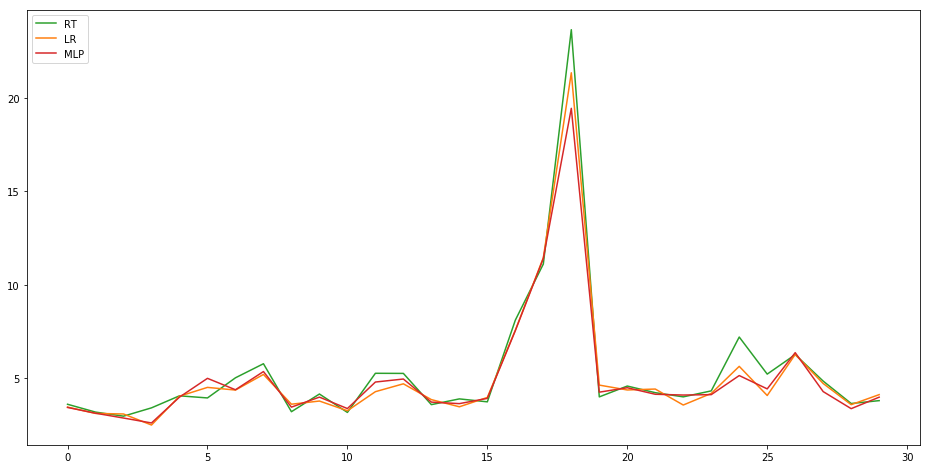

In [7]:
for reg in regs:
    plt.plot(df_rmse[reg], colors[reg], label=reg)
plt.legend(loc='upper left')
plt.show()

# Plot

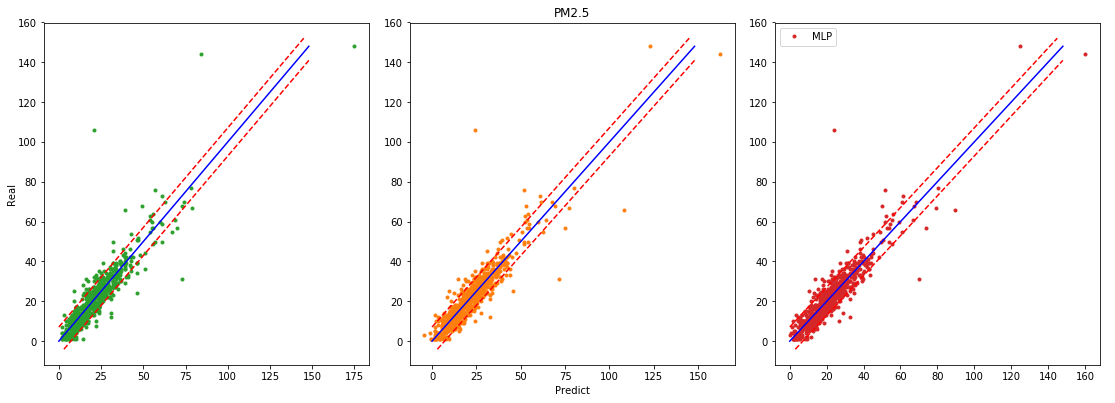

In [12]:
plt.rcParams['figure.figsize'] = [16.0, 6.0]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.title.set_text(target)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')
ax.set_xlabel('Predict')
ax.set_ylabel('Real')

subplot = {'RT':131, 'LR':132, 'MLP':133}
for reg in regs:
    sub_ax = fig.add_subplot(subplot[reg])
    sub_ax.plot(df_prdict[reg], real, colors[reg] + '.', label=reg)
    
    a, b = 0, max(max(real), 24)
    mrange = 5 * sqrt(2)
    sub_ax.plot([a, b], [a, b], 'b-')
    sub_ax.plot([a, b - 3], [a+mrange, b+mrange -3], 'r--')
    sub_ax.plot([a + 3, b], [a-mrange + 3, b-mrange], 'r--')
    
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Output

In [13]:
importances

,AMB_TEMP,RAINFALL,RH,WIND_SPEED,hour_0,hour_1,hour_10,hour_11,hour_12,hour_13,...,t-4,t-5,t-6,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,0.005652,0.001020,0.019032,0.007149,0.000254,0.000176,0.000256,0.000374,0.000242,0.000245,...,0.037112,0.006821,0.008514,0.000339,0.000430,0.004694,0.001084,0.000381,0.000456,0.000847
1,0.006983,0.000670,0.019798,0.008207,0.000231,0.000149,0.000224,0.000368,0.000283,0.000209,...,0.062674,0.013680,0.006581,0.000307,0.000476,0.004485,0.000559,0.000395,0.000371,0.000498
2,0.007827,0.000648,0.036006,0.010094,0.000238,0.000171,0.000302,0.000394,0.000324,0.000243,...,0.024670,0.051343,0.008686,0.000327,0.000526,0.003378,0.002891,0.000378,0.000727,0.000672
3,0.006557,0.000756,0.020251,0.007983,0.000222,0.000187,0.000349,0.000658,0.000379,0.000342,...,0.029777,0.025687,0.012008,0.000427,0.000531,0.004969,0.002180,0.000486,0.000536,0.000542
4,0.008733,0.001724,0.019860,0.017150,0.000278,0.000264,0.000314,0.000425,0.000246,0.000308,...,0.036037,0.012641,0.010824,0.000396,0.000536,0.006496,0.000678,0.000447,0.000640,0.000675
5,0.005762,0.000915,0.030564,0.009417,0.000203,0.000212,0.000398,0.000446,0.000326,0.000258,...,0.033137,0.026555,0.010033,0.000455,0.000782,0.003471,0.000586,0.000469,0.000658,0.000545
6,0.009622,0.000819,0.014821,0.008528,0.000281,0.000196,0.000311,0.000584,0.000246,0.000228,...,0.034209,0.018412,0.010367,0.000428,0.000651,0.005377,0.000986,0.000434,0.000703,0.000518
7,0.007172,0.000906,0.031415,0.014157,0.000226,0.000190,0.000298,0.000451,0.000356,0.000231,...,0.020621,0.054729,0.014867,0.000374,0.000472,0.005115,0.000961,0.000431,0.000948,0.000584
8,0.006649,0.000866,0.012824,0.012006,0.000229,0.000208,0.000362,0.000422,0.000273,0.000298,...,0.028758,0.013964,0.008953,0.000383,0.000536,0.003762,0.001713,0.000386,0.000403,0.000710
9,0.007241,0.000804,0.011119,0.014973,0.000202,0.000155,0.000285,0.000456,0.000293,0.000256,...,0.039957,0.011468,0.012097,0.000321,0.000460,0.004266,0.000758,0.000364,0.000482,0.000469


In [14]:
coefficients

,AMB_TEMP,RAINFALL,RH,WIND_SPEED,hour_0,hour_1,hour_10,hour_11,hour_12,hour_13,...,t-4,t-5,t-6,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,-0.106473,-0.293095,-0.016722,-0.331785,-0.603948,-0.713239,0.233942,0.921102,0.442012,-0.733389,...,0.487270,-0.051899,-0.044628,-0.111588,-0.102197,-0.019143,0.145671,-0.120872,0.334481,-0.126353
1,-0.107034,-0.292803,-0.016840,-0.332815,-0.612214,-0.717762,0.248245,0.924742,0.450715,-0.714454,...,0.486949,-0.051122,-0.044920,-0.110788,-0.101337,-0.018266,0.140004,-0.119931,0.335745,-0.125427
2,-0.107261,-0.292836,-0.016913,-0.333432,-0.608147,-0.720699,0.255729,0.938401,0.446620,-0.701143,...,0.487289,-0.051385,-0.045011,-0.110479,-0.100921,-0.017953,0.140574,-0.122747,0.336303,-0.124777
3,-0.108767,-0.292463,-0.017199,-0.334004,-0.613086,-0.720723,0.261814,0.951346,0.436759,-0.687009,...,0.487159,-0.050931,-0.045236,-0.108538,-0.099266,-0.016002,0.143238,-0.119605,0.322468,-0.122295
4,-0.108945,-0.292415,-0.017192,-0.334499,-0.617090,-0.721272,0.264932,0.940589,0.434894,-0.679789,...,0.486957,-0.050541,-0.045453,-0.108479,-0.099142,-0.015947,0.143329,-0.119539,0.322662,-0.122884
5,-0.108173,-0.292617,-0.017040,-0.333098,-0.616610,-0.726443,0.237370,0.941133,0.420150,-0.655929,...,0.486560,-0.049332,-0.046179,-0.102663,-0.099919,-0.016769,0.142397,-0.120592,0.321437,-0.123890
6,-0.104382,-0.289883,-0.017848,-0.326573,-0.600974,-0.701839,0.244641,0.931333,0.386022,-0.680470,...,0.487010,-0.050164,-0.046111,-0.109713,-0.064153,-0.021177,0.137104,-0.125485,0.313861,-0.130437
7,-0.105265,-0.289926,-0.017774,-0.325759,-0.602818,-0.686562,0.238374,0.921541,0.385269,-0.673686,...,0.487019,-0.049283,-0.046706,-0.107508,-0.062319,-0.035622,0.139408,-0.122849,0.316625,-0.127734
8,-0.106733,-0.290070,-0.018001,-0.326851,-0.596008,-0.696853,0.287921,0.928439,0.390004,-0.708111,...,0.487111,-0.049225,-0.046809,-0.105014,-0.060109,-0.033264,0.122734,-0.119735,0.320075,-0.124688
9,-0.107374,-0.290675,-0.017799,-0.324859,-0.601968,-0.677005,0.286300,0.942654,0.409254,-0.706439,...,0.486478,-0.048639,-0.046835,-0.102350,-0.058377,-0.031158,0.125202,-0.133787,0.322580,-0.122110


In [15]:
importances.to_csv('../output/RT_importances.csv', index=False)

In [16]:
coefficients.to_csv('../output/LR_coefficients.csv', index=False)